In [2]:
import argparse
import sys
import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from torchtext import data as D
from torchtext import datasets

In [3]:
# Set necessary parameters. 
sys.argv = ["python"]
parser = argparse.ArgumentParser()
parser.add_argument("-c", "--cuda", help="Use GPU or not.", action="store_true", default=True)
parser.add_argument("-s", "--seed", help="Random seed of experiment.", type=int, default=1991)
parser.add_argument("-b", "--batch", help="Batch size.", type=int, default=100)
parser.add_argument("-e", "--epoch", help="Number of training epochs.", type=int, default=100)
parser.add_argument("-r", "--lrate", help="Learning rate.", type=float, default=0.1)
parser.add_argument("-t", "--tau", help="Coefficient for the L2-regularization", type=float, default=1e-2)

# Compile and configure all the parameters.
args = parser.parse_args()
args.cuda = args.cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.set_num_threads(8)

In [4]:
# Define a basic RNN module using Pytorch.
class SimpleRNN(nn.Module):
    """
    Simple recurrent neural network for classification.
    """
    def __init__(self, configs):
        super(SimpleRNN, self).__init__()
        self.embed_dim = configs["embed_dim"]
        self.dict_size = configs["dict_size"]
        # Initialize the word2vec.
        self.embedding = nn.Embedding(self.dict_size, self.embed_dim)
        self.embedding.weight = nn.Parameter(configs["vocab"].vectors, requires_grad=True)
        # Model hyperparameter.
        self.num_neurons = configs["hidden_neuron"]
        # Recurrent layer.
        self.rnn = nn.RNN(input_size=self.embed_dim, hidden_size=self.num_neurons, 
            num_layers=1, bidirectional=False)
        # Mean pooling for classification.
        self.classifier = nn.Linear(self.num_neurons, 2)
        # Get the handler of the recurrent connection matrix in RNN.
        self.recurrent_matrix = list(self.rnn.parameters())[1]
        print("Model architecture: {}".format(self))

    def init_hiddens(self, batch_size, is_cuda=True):
        h0 = Variable(torch.zeros(1, batch_size, self.num_neurons))
        if is_cuda:
            h0 = h0.cuda()
        return h0

    def forward(self, inputs, is_cuda=True):
        batch_size = inputs.size()[1]
        self.h0 = self.init_hiddens(batch_size, is_cuda)
        # Initialize hidden vectors for the central recurrent layer.
        embeddings = self.embedding(inputs)
        # Recurrent process.
        hiddens = embeddings.view(len(inputs), batch_size, self.embed_dim)
        hiddens, _ = self.rnn(hiddens, self.h0)
        # Mean pooling.
        summary = torch.mean(hiddens, 0)
        # Final binary classification layer.
        logits = F.log_softmax(self.classifier(summary), dim=1)
        return logits

In [5]:
# Preprocessing using the package torchtext.
# Text preprocessing.
TEXT = D.Field(sequential=True, tokenize=D.get_tokenizer("spacy"), lower=True)
LABEL = D.Field(sequential=False, use_vocab=False)
train, valid, test = D.TabularDataset.splits(path="./SST2/", train="train.tsv", 
    validation="dev.tsv", test="test.tsv", format="tsv", fields=[("text", TEXT), ("label", LABEL)])
num_train, num_valid, num_test = len(train), len(valid), len(test)
print("Number of training sentences = {}".format(num_train))
print("Number of validation sentences = {}".format(num_valid))
print("Number of test sentences = {}".format(num_test))
train_iter, valid_iter, test_iter = D.Iterator.splits((train, valid, test), sort_key=lambda x: len(x.text), 
    batch_sizes=(args.batch, args.batch, args.batch), repeat=False, device=-1)
TEXT.build_vocab(train, vectors="glove.6B.50d")
vocab = TEXT.vocab

.vector_cache/glove.6B.zip: 0.00B [00:00, ?B/s]

Number of training sentences = 6920
Number of validation sentences = 872
Number of test sentences = 1821


FileNotFoundError: [Errno 2] No such file or directory: '.vector_cache/glove.6B.zip'

In [ ]:
# Initialize model training configuration
learn_rate = args.lrate
batch_size = args.batch
num_hidden = 200
num_epochs = args.epoch
num_batches = len(train_iter)

In [17]:
print("SimpleRNN model for sentiment analysis on SST2 dataset.")
trainiter = train_iter
# Configuration of all the model and training hyperparameters.
configs = {"embed_dim": 50, "dict_size": len(vocab), "vocab": vocab, "batch_size": args.batch,
    "hidden_neuron": num_hidden, "is_cuda": args.cuda, "num_epochs": num_epochs, "lr": args.lrate}
print("Hyperparameter setting = {}.".format(configs))

SimpleRNN model for sentiment analysis on SST2 dataset.
Hyperparameter setting = {'embed_dim': 50, 'dict_size': 13833, 'vocab': <torchtext.vocab.Vocab object at 0x7f5329418160>, 'batch_size': 100, 'hidden_neuron': 200, 'is_cuda': True, 'num_epochs': 100, 'lr': 0.1}.


In [18]:
print("Batch size = {}, number of batch = {}.".format(batch_size, len(trainiter)))
# Build model.
train_loss = []
train_accurcay, valid_accuracy = [], []
nnet = SimpleRNN(configs)
criterion = nn.NLLLoss()
optimizer = optim.Adadelta(filter(lambda p: p.requires_grad, nnet.parameters()), lr=learn_rate, weight_decay=args.tau)
# Learning rate scheduler.
milestones = [25, 50, 80]
scheduler = MultiStepLR(optimizer, milestones, gamma=0.1)
if args.cuda:
    nnet = nnet.cuda()
start_time = time.time()
# Training phase.
for k in range(num_epochs):
    nnet.train()
    scheduler.step()
    tot_loss = 0.0
    tot_corr = 0.0
    # On training set.
    for batch in trainiter:
        xs, ys = batch.text, batch.label
        if args.cuda:
            xs, ys = xs.cuda(), ys.cuda()
        optimizer.zero_grad()
        ypreds = nnet(xs, args.cuda)
        loss = criterion(ypreds, ys)
        loss.backward()
        optimizer.step()
        tot_loss += loss.data[0]
        # Compute the number of correct predictions on the training set. 
        if args.cuda:
            preds = ypreds.data.cpu().numpy()
            trues = batch.label.data.cpu().numpy()
        else:
            preds = ypreds.data.numpy()
            trues = batch.label.data.numpy()
        preds = np.argmax(preds, axis=1)
        tot_corr += np.sum(preds == trues)
    train_loss.append(tot_loss)
    train_accurcay.append(tot_corr / num_train)
    print("Iteration Number: {}, training set loss = {}".format(k, tot_loss))
    # Monitor the performance on the validation set. 
    nnet.eval()
    tot_corr = 0.0
    for batch in valid_iter:
        xs, ys = batch.text, batch.label
        if args.cuda:
            xs, ys = xs.cuda(), ys.cuda()
        ypreds = nnet(xs)
        if args.cuda:
            preds = ypreds.data.cpu().numpy()
            trues = batch.label.data.cpu().numpy()
        else:
            preds = ypreds.data.numpy()
            trues = batch.label.data.numpy()
        preds = np.argmax(preds, axis=1)
        tot_corr += np.sum(preds == trues)
    valid_accuracy.append(tot_corr / num_valid)
end_time = time.time()
print("*" * 50)
print("Time used for training on SST dataset = {} seconds.".format(end_time - start_time))

Batch size = 100, number of batch = 70.
Model architecture: SimpleRNN(
  (embedding): Embedding(13833, 50)
  (rnn): RNN(50, 200)
  (classifier): Linear(in_features=200, out_features=2, bias=True)
)
Iteration Number: 0, training set loss = 48.259426057338715
Iteration Number: 1, training set loss = 47.88461619615555
Iteration Number: 2, training set loss = 46.86770957708359
Iteration Number: 3, training set loss = 44.050664365291595
Iteration Number: 4, training set loss = 41.99932253360748
Iteration Number: 5, training set loss = 40.98215273022652
Iteration Number: 6, training set loss = 39.984184235334396
Iteration Number: 7, training set loss = 39.6195926964283
Iteration Number: 8, training set loss = 39.93135169148445
Iteration Number: 9, training set loss = 38.88563331961632
Iteration Number: 10, training set loss = 38.890257984399796
Iteration Number: 11, training set loss = 38.516923636198044
Iteration Number: 12, training set loss = 38.284611225128174
Iteration Number: 13, train

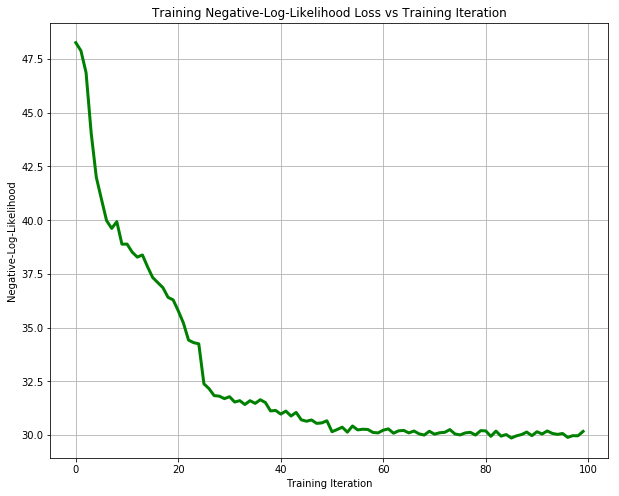

In [19]:
# Visualization to better understand the training process.
%matplotlib inline
import matplotlib.pyplot as plt

# Training NLL loss versus training iteration.
plt.figure(figsize=(10, 8))
plt.title("Training Negative-Log-Likelihood Loss vs Training Iteration")
plt.xlabel("Training Iteration")
plt.ylabel("Negative-Log-Likelihood")
plt.grid(True)
plt.plot(np.arange(num_epochs), train_loss, linewidth=3, color="g")

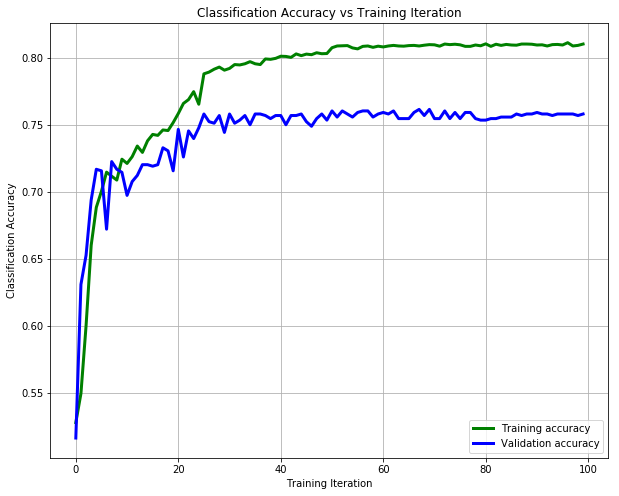

In [20]:
# Training versus validation set classification accuracy. 
plt.figure(figsize=(10, 8))
plt.title("Classification Accuracy vs Training Iteration")
plt.xlabel("Training Iteration")
plt.ylabel("Classification Accuracy")
plt.grid(True)
plt.plot(np.arange(num_epochs), train_accurcay, linewidth=3, color="g")
plt.plot(np.arange(num_epochs), valid_accuracy, linewidth=3, color="b")
plt.legend(["Training accuracy", "Validation accuracy"], loc=4)

In [21]:
# Evaluation phase on the test set. 
nnet.eval()
num_correct = 0.0
for batch in test_iter:
    xs, ys = batch.text, batch.label
    if args.cuda:
        xs, ys = xs.cuda(), ys.cuda()
    ypreds = nnet(xs)
    if args.cuda:
        preds = ypreds.data.cpu().numpy()
        trues = batch.label.data.cpu().numpy()
    else:
        preds = ypreds.data.numpy()
        trues = batch.label.data.numpy()
    preds = np.argmax(preds, axis=1)
    num_correct += np.sum(preds == trues)
accuracy = num_correct / num_test
print("Number of correct predictions = {}, Test set accuracy = {:.4f}".format(num_correct, accuracy))

Number of correct predictions = 1330.0, Test set accuracy = 0.7304
